In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import numpy as np

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
1,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
2,deg=3,polynomial_regression_1dim,Transformer,,-1,-1,1,12,8,polynomial_regression_1_dim
3,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
6,large,sine2exp,Transformer-large,"A_range=[0.1, 5.0]_B_range=[0.1, 5.0]_C_range=...",-1,-1,1,16,12,sine2exp
4,pretrained,sine_task,Transformer,"A_range=[0.1, 5.0]_B_range=[0.1, 5.0]_C_range=...",-1,-1,5,12,8,sine_task
5,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [3]:
#task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"
#task = 'sine2cosine'
#task = 'sine2periodic'
task = "sine2exp"
#run_id = "pretrained"  # if you train more models, replace with the run_id from the table above
run_id = 'large'
run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path, skip_baselines=False, cache=False)

# Plot pre-computed metrics

In [4]:
import numpy as np

def large_plot(metrics, models=None, trivial=1.0, clip_quantile=1.0, max_ylim=None):
    fig, ax = plt.subplots(1, 1)

    if models is not None:
        metrics = {k: metrics[k] for k in models if k in metrics}

    color = 0
    # ax.axhline(trivial, ls="--", color="gray")

    all_high_vals = []

    for name, vs in metrics.items():
        mean = vs["mean"]
        low = vs["bootstrap_low"]
        high = vs["bootstrap_high"]

        ax.plot(mean, "-", label=name, color=palette[color % 10], lw=2)
        # ax.fill_between(range(len(low)), low, high, alpha=0.3)

        all_high_vals.extend(high)
        color += 1

    ax.set_xlabel("in-context examples")
    ax.set_ylabel("squared error")

    # 设定 y 轴最大值
    if len(all_high_vals) > 0:
        y_upper = np.quantile(all_high_vals, clip_quantile)  # 默认取 95% 分位数
        if max_ylim is not None:
            y_upper = min(y_upper, max_ylim)
        ax.set_ylim(-0.1, y_upper * 1.1)
    else:
        ax.set_ylim(-0.1, 1.0)

    legend = ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    fig.set_size_inches(5, 4)
    for line in legend.get_lines():
        line.set_linewidth(3)

    return fig, ax


In [5]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

# metrics = collect_results(run_dir, df, valid_row=valid_row)
metrics = get_run_metrics(run_path, cache=False, skip_baselines=False)

100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


dict_keys(['gpt2_embd=768_layer=16_head=12', 'OLS_driver=None', 'NN_n=3_uniform', 'averaging'])


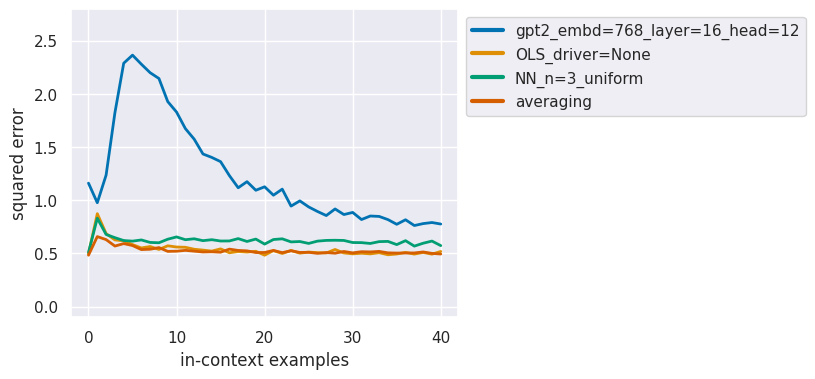

gpt2_embd=768_layer=16_head=12: {'mean': [1.1610238552093506, 0.9765580296516418, 1.2364447116851807, 1.8226230144500732, 2.28852915763855, 2.364530086517334, 2.279407501220703, 2.199373722076416, 2.1447761058807373, 1.9275964498519897, 1.8292043209075928, 1.6738450527191162, 1.5745900869369507, 1.4350017309188843, 1.402772068977356, 1.3629436492919922, 1.2318816184997559, 1.1173932552337646, 1.1748079061508179, 1.094038486480713, 1.126612901687622, 1.0475378036499023, 1.104461908340454, 0.9449554681777954, 0.9941345453262329, 0.937376856803894, 0.8946598768234253, 0.8561911582946777, 0.918270468711853, 0.8655692934989929, 0.885472297668457, 0.8187074661254883, 0.8518513441085815, 0.84807950258255, 0.8183072805404663, 0.7739525437355042, 0.8165478706359863, 0.7623289227485657, 0.7805615663528442, 0.7906173467636108, 0.7764471173286438], 'std': [1.531217336654663, 1.2519131898880005, 1.8704854249954224, 3.0834996700286865, 3.656981945037842, 3.6862664222717285, 3.4217259883880615, 3.537

In [6]:
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

# models = relevant_model_names[task]
models = list(metrics["standard"].keys())

print(metrics["standard"].keys())

# basic_plot(metrics["standard"], models=models)
large_plot(metrics["standard"], models=models)
plt.show()

for model in models:
    if model in metrics["standard"]:
        loss_tensor = metrics["standard"][model]
        print(f"{model}: {loss_tensor}")
    else:
        print(f"{model}: not found in metrics")


In [7]:
def find_stable_mean(loss_values, window_size=5, std_threshold=0.02):
    losses = np.array(loss_values)
    n = len(losses)

    for i in range(n - window_size):
        window = losses[i:i + window_size]
        if np.std(window) < std_threshold:
            stable_mean = np.mean(losses[i:])
            return stable_mean, i

    print("No window found!")
    return np.mean(losses), None

loss_seq = metrics["standard"]["gpt2_embd=768_layer=16_head=12"]["mean"]
stable_mean, start_idx = find_stable_mean(loss_seq, window_size=5, std_threshold=0.02)

print(f"稳定均值: {stable_mean:.4f}")
if start_idx is not None:
    print(f"开始稳定于 index={start_idx}")
else:
    print("未找到稳定区间，使用全体平均")


稳定均值: 0.7834
开始稳定于 index=35


In [8]:
from models import TransformerModel

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

model = TransformerModel(
    n_dims=conf.model.n_dims,
    n_positions=conf.model.n_positions,
    n_embd=conf.model.n_embd,
    n_layer=conf.model.n_layer,
    n_head=conf.model.n_head,
)
total, trainable = count_parameters(model)
print(f"  Total Parameters: {total:,}")
print(f"  Trainable Parameters: {trainable:,}")

  Total Parameters: 152,162,305
  Trainable Parameters: 152,162,305


In [9]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [10]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [11]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [12]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs,mode="sine")

In [13]:
print(xs[0][0])

tensor([-0.0238])


In [14]:
print(ys[0][0])

tensor(0.4623)


In [15]:
with torch.no_grad():
    pred = model(xs, ys)

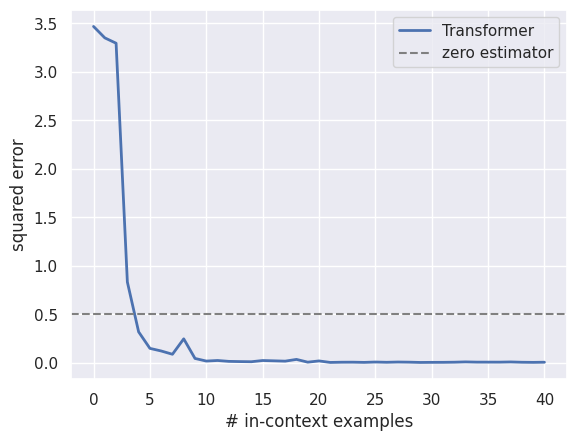

In [16]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
    "sine_regression": 1.0,
    "sine2cosine":1,
    "sine2periodic":1,
    "poly_function_regression":125,
    "hard_sine2sawtooth":0.5,
    "hard_sine2square":0.5,
    "poly2tanhregression":1.5,
    "poly_to_softsign_regression":25,
    "sine2exp":0.5,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [17]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2, mode="sine")
with torch.no_grad():
    pred2 = model(xs2, ys2)

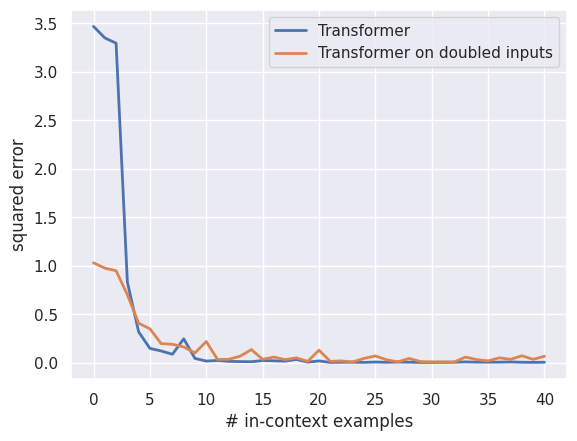

In [18]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.

In [19]:
with torch.no_grad():
    # 获取模型中参数所在的设备
    device = next(model.parameters()).device

    # 构造输入为全 0 的向量
    zero_xs = torch.zeros_like(xs).to(device)
    ys_on_device = torch.ones_like(ys).to(device)

    pred_zero = model(zero_xs, ys_on_device)

    print("The result when input is zeros:")
    print(pred_zero.cpu())
    print(ys_on_device.cpu())
    print(zero_xs)


The result when input is zeros:
tensor([[1.6569, 1.0729, 1.0636,  ..., 1.0153, 1.0140, 1.0131],
        [1.6569, 1.0729, 1.0636,  ..., 1.0153, 1.0140, 1.0131],
        [1.6569, 1.0729, 1.0636,  ..., 1.0153, 1.0140, 1.0131],
        ...,
        [1.6569, 1.0729, 1.0636,  ..., 1.0153, 1.0140, 1.0131],
        [1.6569, 1.0729, 1.0636,  ..., 1.0153, 1.0140, 1.0131],
        [1.6569, 1.0729, 1.0636,  ..., 1.0153, 1.0140, 1.0131]])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],